KOSPI Stochastic Volatility Prediction 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data=pd.read_csv('./data/kospi_daily.csv',index_col=0, parse_dates=True)
returns=data['Close'].pct_change().dropna()*100
split=60

In [3]:
# Log Chi-Square Approximation Parameters
# Stochastic volatility with leverage: fast and efficient likelihood inference paper's Table 1
# https://www.economics.uci.edu/files/docs/colloqpapers/w06/chib.pdf
LOG_CHI_SQ_APPROX_PARAMS={
    'p':[0.00609, 0.04775, 0.13057, 0.20674, 0.22715, 0.18842, 0.12047, 0.05591, 0.01575, 0.00115],
    'mean':[1.92677, 1.34744, 0.73504, 0.02266, -0.85173, -1.97278, -3.46788, -5.55246, -8.68384, -14.65000],
    'var':[0.11265, 0.17788, 0.26768, 0.40611, 0.62699, 0.98583, 1.57469, 2.54498, 4.16591, 7.33342]
}

Sampling Functions

In [4]:
def sample_mu_phi(latent_volatility:pd.Series, parameter_dict:dict, sigma2_eta:float)->np.ndarray:
    T=len(latent_volatility)
    h=latent_volatility.values
    z=np.vstack((np.ones(T-1), h[:-1])).T # (T-1,2)
    y=h[1:] # (T-1,)

    mu_phi_mean_prior=parameter_dict['mu_phi_mean']
    mu_phi_var_prior=parameter_dict['mu_phi_cov']

    mu_phi_var_post=np.linalg.inv(np.linalg.inv(mu_phi_var_prior)+np.dot(z.T,z)/sigma2_eta)
    mu_phi_mean_post= mu_phi_var_post @ (np.linalg.inv(mu_phi_var_prior) @ mu_phi_mean_prior + np.dot(z.T,y)/sigma2_eta)
    
    m_mu, m_phi=mu_phi_mean_post
    v_mm, v_mphi, v_phim, v_phiphi=mu_phi_var_post[0,0], mu_phi_var_post[0,1], mu_phi_var_post[1,0], mu_phi_var_post[1,1]

    # phi ~ Truncnorm(-1,1, loc=m_phi, scale=np.sqrt(v_phiphi))
    a, b = (-1 - m_phi) / np.sqrt(v_phiphi), (1 - m_phi) / np.sqrt(v_phiphi)
    sampled_phi=stats.truncnorm.rvs(a, b, loc=m_phi, scale=np.sqrt(v_phiphi))

    # 2) mu | phi
    mu_cond=m_mu + v_mphi/v_phiphi*(sampled_phi - m_phi)
    var_cond=v_mm-v_mphi*v_phim/v_phiphi
    mu=stats.norm.rvs(loc=mu_cond, scale=np.sqrt(var_cond))
    return mu, sampled_phi

def sample_sigma2_eta(latent_volatility:pd.Series, parameter_dict:dict, mu:float, phi:float)->float:
    T=len(latent_volatility)
    h=latent_volatility.values
    residuals=h[1:] - mu - phi*(h[:-1]-mu)
    alpha_prior=parameter_dict['sigma2_shape']
    beta_prior=parameter_dict['sigma2_scale']
    alpha_post=(alpha_prior + (T-1))/2
    beta_post=(beta_prior + np.sum(residuals**2))/2
    sampled_sigma2_eta=stats.invgamma.rvs(a=alpha_post, scale=beta_post)
    return sampled_sigma2_eta

def sample_states(latent_volatility:pd.Series, returns_log_sq:pd.Series, parameter_dict:dict, mu:float, phi:float, sigma2_eta:float)->np.ndarray:
    T=len(latent_volatility)
    h=latent_volatility.values
    # Step 1: Sample mixture indicators
    states=np.zeros(T, dtype=int)
    m=len(LOG_CHI_SQ_APPROX_PARAMS['p'])
    for t in range(T):
        post_prob=np.zeros(m)
        for i in range(m):
            post_prob[i]=stats.norm.pdf(returns_log_sq.iloc[t], loc=LOG_CHI_SQ_APPROX_PARAMS['mean'][i]+h[t], scale=np.sqrt(LOG_CHI_SQ_APPROX_PARAMS['var'][i]))*LOG_CHI_SQ_APPROX_PARAMS['p'][i]
        post_prob=post_prob/np.sum(post_prob)
        states[t]=np.random.choice(np.arange(m), p=post_prob)
    return states

def sample_latent_volatility(latent_volatility:pd.Series, returns_log_sq:pd.Series, parameter_dict:dict, mu:float, phi:float, sigma2_eta:float, states:np.ndarray):
    T=len(latent_volatility)

    # 1. Kalman Filter
    h_t=np.zeros(T)
    h_t_var=np.zeros((T))
    h_prior=mu/(1-phi)
    h_prior_var=sigma2_eta/(1-phi**2)

    for t in range(T):
        h_pred=mu + phi*h_prior
        h_pred_var=phi**2*h_prior_var + sigma2_eta

        returns_log_sq_pred=h_pred + LOG_CHI_SQ_APPROX_PARAMS['mean'][states[t]]
        returns_log_sq_pred_var=h_pred_var + LOG_CHI_SQ_APPROX_PARAMS['var'][states[t]]

        kalman_gain=h_pred_var/returns_log_sq_pred_var

        h_t[t]=h_pred + kalman_gain*(returns_log_sq.iloc[t]-returns_log_sq_pred)
        h_t_var[t]=(1-kalman_gain)*h_pred_var

        h_prior=h_t[t]
        h_prior_var=h_t_var[t]

    # 2. Backward Sampling
    h_sample=np.zeros(T)
    h_sample[-1]=np.random.normal(h_t[-1], np.sqrt(h_t_var[-1])) # Sample h_T

    for t in range(T-2, -1, -1):
        h_pred=mu + phi*h_t[t]
        h_pred_var=phi**2*h_t_var[t] + sigma2_eta

        h_sample_mean=h_t[t]+h_t_var[t]*phi/h_pred_var*(h_sample[t+1]-h_pred)
        h_sample_var=h_t_var[t]-h_t_var[t]**2*phi**2/h_pred_var

        h_sample[t]=np.random.normal(h_sample_mean, np.sqrt(h_sample_var))

    return h_sample

In [5]:
def forecast(latent_volatility:pd.Series, parameter_dict:dict, mu:float, phi:float, sigma2_eta:float, steps:int=1)->np.ndarray:
    h=latent_volatility.values

    h_forecast=np.zeros(steps)
    h_forecast[0]=mu + phi*(h[-1]-mu)+np.random.normal(0, np.sqrt(sigma2_eta))
    for t in range(1, steps):
        h_forecast[t]=mu + phi*(h_forecast[t-1]-mu)+np.random.normal(0, np.sqrt(sigma2_eta))
    
    vol_forecast=np.exp(h_forecast/2)
    return_forecast=np.random.normal(0, vol_forecast)
    return return_forecast, vol_forecast


Main

In [6]:
def fit_and_predict(returns_train:pd.Series, forecasts_steps:int=10, burn_in:int=500, n_samples:int=5000):
    # set prior parameters
    mu_phi_mean=[-0.2, 0.9]
    mu_phi_cov=np.eye(len(mu_phi_mean))*0.1

    sigma2_shape=12.0
    sigma2_scale=2.0
    sigma2=sigma2_scale*0.5/(sigma2_shape*0.5-1)

    mean_returns=returns_train.mean()
    eps=1e-6
    return_train_log_sq=np.log((returns_train-mean_returns)**2+eps)
    latent_volatility=return_train_log_sq.copy()

    parameter_dict={
        'mu_phi_mean':mu_phi_mean,
        'mu_phi_cov':mu_phi_cov,
        'sigma2_shape':sigma2_shape,
        'sigma2_scale':sigma2_scale
    }

    latent_volatility_samples=np.zeros((n_samples, len(returns_train)))
    volatility_samples=np.zeros((n_samples, len(returns_train)))
    forecast_return_samples=np.zeros((n_samples, forecasts_steps))
    forecast_volatility_samples=np.zeros((n_samples, forecasts_steps))

    for i in tqdm(range(burn_in+n_samples), desc="MCMC Sampling"):
        mu_phi=sample_mu_phi(latent_volatility, parameter_dict, sigma2)
        mu, phi=mu_phi

        sigma2=sample_sigma2_eta(latent_volatility, parameter_dict, mu, phi)

        states=sample_states(latent_volatility, return_train_log_sq, parameter_dict, mu, phi, sigma2)

        latent_volatility_values=sample_latent_volatility(latent_volatility, return_train_log_sq, parameter_dict, mu, phi, sigma2, states)

        latent_volatility=pd.Series(latent_volatility_values, index=returns_train.index)
        volatility=np.exp(latent_volatility/2)
        return_pred, vol_pred=forecast(latent_volatility, parameter_dict, mu, phi, sigma2, steps=forecasts_steps)
        if i>=burn_in:
            latent_volatility_samples[i-burn_in]=latent_volatility.values
            volatility_samples[i-burn_in]=volatility.values
            forecast_return_samples[i-burn_in]=return_pred
            forecast_volatility_samples[i-burn_in]=vol_pred    
    return latent_volatility_samples, volatility_samples, forecast_return_samples, forecast_volatility_samples


In [7]:
from joblib import Parallel, delayed

forecast_steps=5
forecast_results=np.zeros((split//5, 4, forecast_steps)) # (num_forecasts, (mean_return, lower_return, upper_return, mean_vol), steps)

def run_forecast(forecast_end, split, returns, forecast_steps):
    returns_train=returns[returns.index>='2010-01-01'][:-(split-forecast_end)]
    returns_test=returns.iloc[-(split-forecast_end):-(split-forecast_end-5)] if (split-forecast_end-5)!=0 else returns.iloc[-(split-forecast_end):]
    latent_volatility_samples, volatility_samples, forecast_return_samples, forecast_volatility_samples=fit_and_predict(returns_train, forecasts_steps=len(returns_test), burn_in=100, n_samples=100)
    train_mean=np.mean(returns_train)
    forecast_return_mean=np.mean(forecast_return_samples, axis=0)+train_mean
    forecast_return_lower=np.percentile(forecast_return_samples, 2.5, axis=0)+train_mean
    forecast_return_upper=np.percentile(forecast_return_samples, 97.5, axis=0)+train_mean
    forecast_volatility_mean=np.mean(forecast_volatility_samples, axis=0)

    result=np.zeros((4, forecast_steps))
    result[0, :len(forecast_return_mean)]=forecast_return_mean
    result[1, :len(forecast_return_lower)]=forecast_return_lower
    result[2, :len(forecast_return_upper)]=forecast_return_upper
    result[3, :len(forecast_volatility_mean)]=forecast_volatility_mean
    return forecast_end//5, result

results = Parallel(n_jobs=-1)(delayed(run_forecast)(forecast_end, split, returns, forecast_steps) for forecast_end in tqdm(range(0, split, forecast_steps), desc='Forecasting'))
for idx, res in results:
    forecast_results[idx] = res



MCMC Sampling: 100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


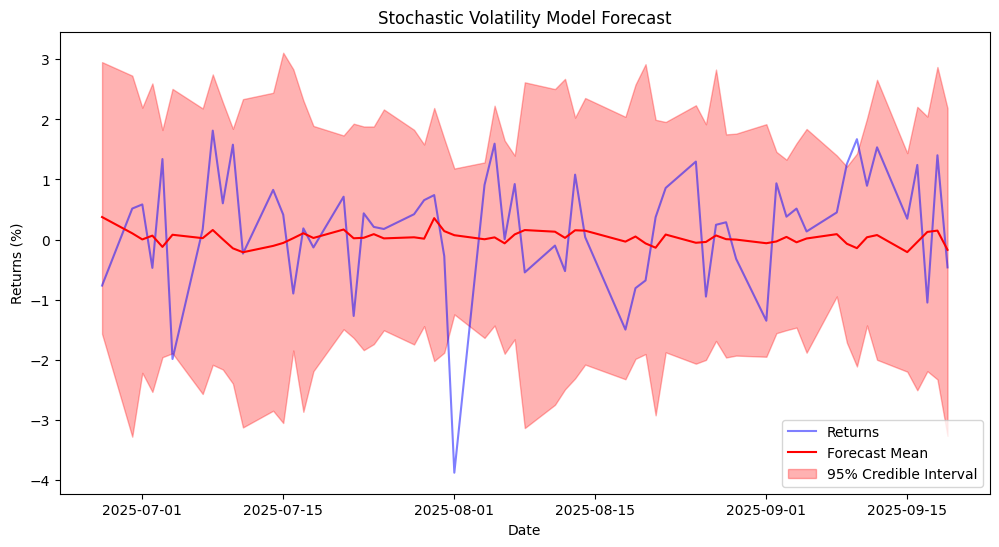

In [8]:
forecast_mean=forecast_results[:,0,:].flatten()
forecast_lower=forecast_results[:,1,:].flatten()
forecast_upper=forecast_results[:,2,:].flatten()
forecast_vol_mean=forecast_results[:,3,:].flatten()


plt.figure(figsize=(12,6))
plt.plot(returns.index[-split:], returns[-split:], label='Returns', color='blue', alpha=0.5)
plt.plot(returns.index[-split:], forecast_mean, label='Forecast Mean', color='red')
plt.fill_between(returns.index[-split:], forecast_lower, forecast_upper, color='red', alpha=0.3, label='95% Credible Interval')
plt.title('Stochastic Volatility Model Forecast')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()